In [1]:
import numpy as np
import h5py
import json
from matplotlib import pyplot as plt
import sys
import os
sys.path.append("../examples")
import json_header as jh


In [2]:
filename = '../examples/084_V01_C02_R001_THx_BL_2S'
atss_data = filename + '.atss'
atss_header = filename + '.json'
# read the header
with open(atss_header) as json_file:
    header = json.load(json_file)
# check if there are doubles inside
if header['atss'] != "double":
    sys.exit("file does not contain doubles")

In [3]:
# file size is and must be in our case samples * 8
samples = int(os.path.getsize(atss_data) / 8)
print ("expecting: ", samples, " samples")
file = open(atss_data, 'rb')
hx = np.fromfile(file, dtype=np.float64)

expecting:  31716  samples


In [4]:
with h5py.File('./demo_surveys.h5', 'w') as hdf:
        su = hdf.create_group('Northern Mining')
        cal = hdf.create_group('Northern Mining/calibration')
        s1 = hdf.create_group(su.name + '/' + header['site'])
        # take a run - so we can later add data from other sensors / transmitters here
        r1 = hdf.create_group(s1.name + '/' + f"{header['run']:03}")
        ds = r1.create_dataset('Hx', data = hx)
        defaults = jh.json_header()
        defaults.pop('site', None)     # used above don't duplicate
        defaults.pop('run', None)      # used above don't duplicate
        for key in defaults.keys():
            ds.attrs[key] = header[key]    
        

In [5]:
# test reading now
with h5py.File('./demo_surveys.h5', 'r') as hdf:
    all_h5_objs = []
    hdf.visit(all_h5_objs.append)
    all_groups   = [ obj for obj in all_h5_objs if isinstance(hdf[obj],h5py.Group) ]
    all_datasets = [ obj for obj in all_h5_objs if isinstance(hdf[obj],h5py.Dataset) ]
    print(all_groups)
    print(all_datasets)  # need some more time for fishing
    
    get = hdf.get('Northern Mining/Sarıçam/001/Hx')
    hxread = np.array(get)
    #print(get.attrs.keys())
    
    # restore my json dictionary
    newheader = {}
    for key, val in get.attrs.items():
            #print("    %s: %s" % (key, val))
            newheader[key] = val
                
    #def print_attrs(name, obj):
    #    print(name)
    #    for key, val in obj.attrs.items():
    #        print("    %s: %s" % (key, val))
    #        
    #hdf.visititems(print_attrs)



['Northern Mining', 'Northern Mining/Sarıçam', 'Northern Mining/Sarıçam/001', 'Northern Mining/calibration']
['Northern Mining/Sarıçam/001/Hx']
ItemsViewHDF5(<Attributes of HDF5 object at 139735958585488>)


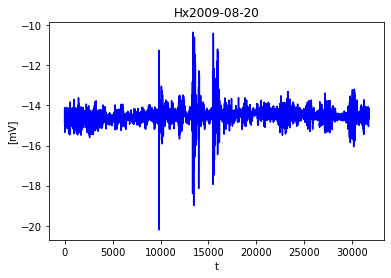

In [7]:
t = range(hxread.size)      # x axis
plt.title( "Hx" + newheader['date'])            # title
plt.xlabel("t")
plt.ylabel("[mV]")
plt.plot(t, hxread, c='b', label='data')
plt.draw()